<a href="https://colab.research.google.com/github/nyp-sit/sdaai-iti107/blob/main/session-7/baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left"/></a>

# Baseline model

Welcome to this week's programming exercise. In this exercise, we will be training a model to recognise if an image depicts positive (e.g. happy, pleasant, beautiful) or negative (e.g. sad, angry, death, etc) emotion . We will first train a baseline model without using transfer learning. The dataset is a collection of around 1600 images from Flickr, and labelled with Positive or Negative label. We only apply data augmentation to our training set. In the next exercise, we will use transfer learning technique to train another model and compare the performance of both.

At the end of this exercise, you will be able to: 
- apply data augmentation to your training data

In [2]:
import os
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from sklearn.metrics import classification_report

import matplotlib
import matplotlib.pyplot as plt


## Download the dataset


In [4]:
dataset_URL = 'https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/iti107/datasets/intel_emotions_dataset.zip'
path_to_zip = tf.keras.utils.get_file('intel_emotions_dataset.zip', origin=dataset_URL, extract=True, cache_dir='.')
print(path_to_zip)

504283136/504272804 [==============================] - 53s 0us/step
./datasets/intel_emotions_dataset.zip


The zip file will be expanded into two subfolders, 'Positive' and 'Negative', containing images that evokes positive emotions and negative emotions respectively. 

In [5]:
dataset_dir = os.path.dirname(path_to_zip)
print(dataset_dir)
pos_path = os.path.join(dataset_dir, 'Positive')
neg_path = os.path.join(dataset_dir, 'Negative')

./datasets


### Visualizing sample images

We randomly select `n_examples` and display them.

**WARNING**: Some of the images may be too graphic and offensive. Please feel free to skip the following two cells. 

In [6]:
n_examples = 5
np.random.seed(42)
positive_expamples = np.random.choice(os.listdir(pos_path), size=n_examples, replace=False)
negative_expamples = np.random.choice(os.listdir(neg_path), size=n_examples, replace=False)

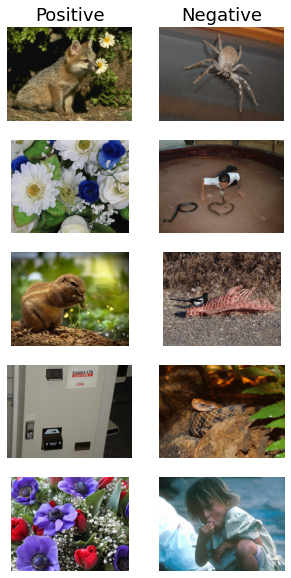

In [7]:
plt.figure(figsize=(5, n_examples * 2))
for i in range(n_examples):
    plt.subplot(n_examples, 2, i * 2 + 1)
    img = keras.utils.load_img(os.path.join(pos_path, positive_expamples[i]))
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title("Positive", fontsize=18)
    plt.subplot(n_examples, 2, i * 2 + 2)
    img = keras.utils.load_img(os.path.join(neg_path, negative_expamples[i]))
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title("Negative", fontsize=18)

## Create train and validation dataset

We will use the tf.keras.preprocessing.image_dataset_from_directory to generate tf.data.Dataset from the data folder. Feel free to adjust the batch_size to the maximum without incurring OOM (out-of-memory) error. GPU usually have limited memory. We also use a smaller image size (128,128) to speed up our training. Although `label_mode` is not required to be specified (and can be infered from the number of subfolders), we specifically set the `label_mode='binary'`, in case our datasets folder contains more than 2 subfolders, as sometimes jupyter notebook will generate a hidden folder called '.ipynb_checkpoints, and keras may think there are 3 different labels. By setting the label_mode to binary allows us to specifically detect this kind of issues. 

In [10]:
batch_size = 8
image_size = (128,128)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)


Found 1630 files belonging to 2 classes.
Using 1304 files for training.
Found 1630 files belonging to 2 classes.
Using 326 files for validation.


In [11]:
# Print the class names 
print(val_ds.class_names)

['Negative', 'Positive']


## Data Augmentation 

Since tensorflow 2.2, Keras introduces new types of layers for doing image data augmentation, such as Random Cropping, Random Flipping, etc. Previously, we have to depend on ImageDataGenerator() (which is a lot slower) to do so. Before tensorflow 2.6, they are available as experimental layers (available in the experimental package), but has been officially supported from tensorflow 2.6 onwards (available as part of the tensorflow.keras.layers).

In the code below, we will check the tensorflow version and instantiate the correct layer depending on the version. We only one RandomRotation layer in the example below. The value `0.3` refers to the maximum rotation angle in both clock-wise and anti-clockwise direction. You can find out more info from the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation)

In [20]:
if tf.version.VERSION >= '2.6.0':
    data_augmentation = keras.Sequential(
        [
            layers.RandomRotation(0.3),
        ]
    )
else: 
    data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomRotation(0.3),
        ]
    )


To see the effects of data augmentation, let us apply our data_augmentation layer to a sample image.

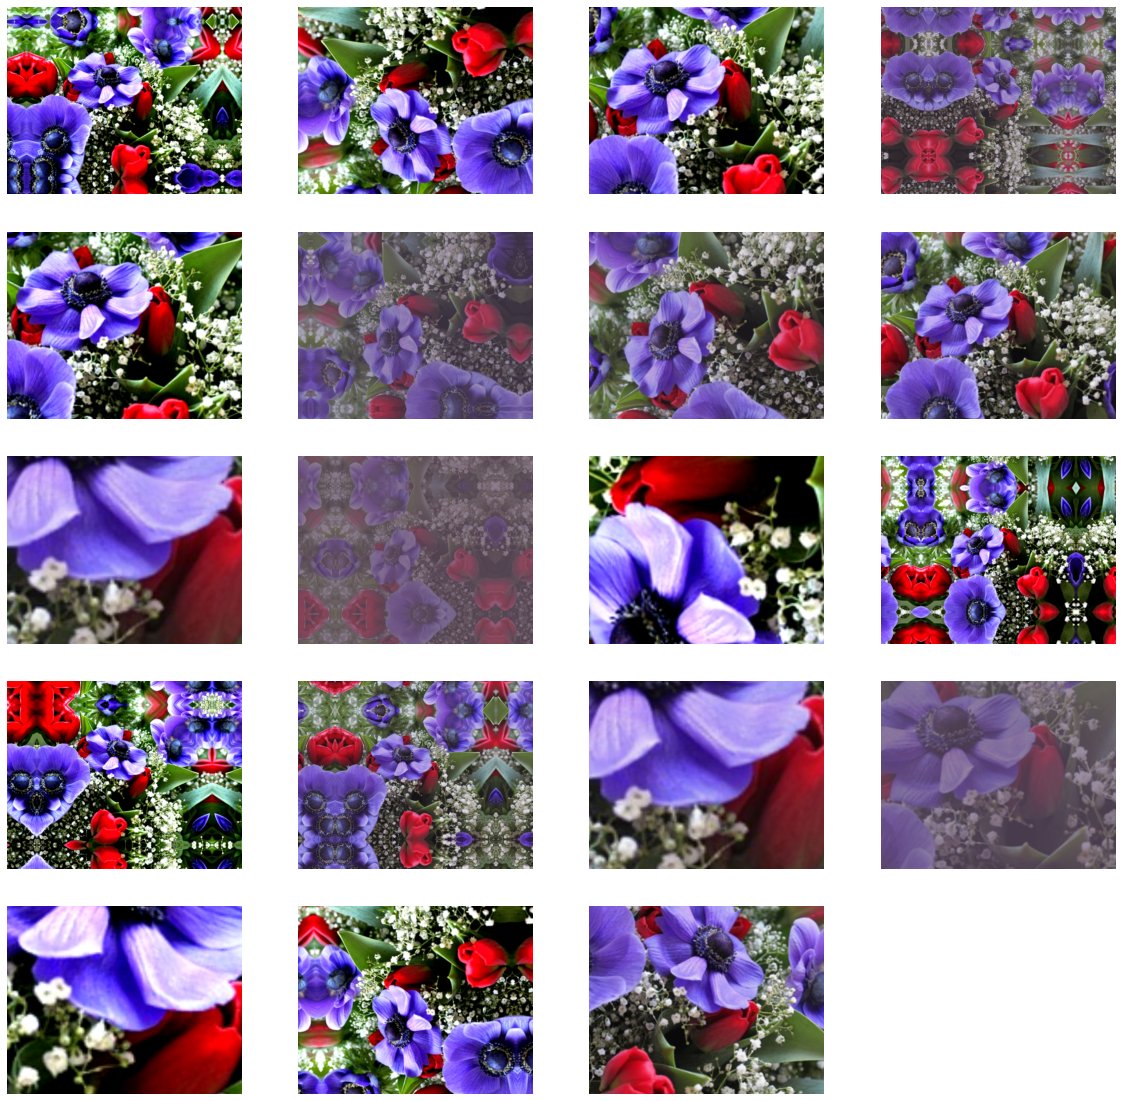

In [39]:
image = keras.utils.load_img(os.path.join(pos_path, positive_expamples[4]))
# plt.imshow(image)
image = tf.expand_dims(image, 0)
plt.figure(figsize=(20, 20))
for i in range(19):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

**Exercise 1:**

Modify the code above to add in Random Contrast and Random Cropping. Choose the appropriate values for the contrast and cropping factor.

<details><summary>Click here for answer</summary>

```python
    
if tf.version.VERSION >= '2.6.0':
    data_augmentation = keras.Sequential(
        [
            layers.RandomRotation(0.3),
            layers.RandomContrast(0.8),
            layers.RandomZoom(0.8)
        ]
    )
else: 
    data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomRotation(0.3),
            layers.experimental.preprocessing.RandomContrast(0.8),
            layers.experimental.preprocessing.RandomZoom(0.8),
        ]
    )

    
```
    
</details>

### Build the model

Previously we have built the mini-Xception network and it works well on our small cats and dogs dataset.  We will apply the same network for this more challenging emotions dataset and see if data augmentation helps.

The following codes are same as previous xception network that you have coded. 

**Exercise 2:**

Modify the code in `make_model()` to apply data augmention layers you have created earlier. Where should you place your augmentation layer?  

<details><summary>Click here for answer</summary>

```python
def make_model(input_shape, num_classes): 
    inputs = keras.Input(shape=input_shape)    
    
    ## Add your augmentation layers here !! 
    x = data_augmentation(inputs) 

    x = layers.Rescaling(1.0 / 255)(inputs)

    ## the rest of the codes.... 
    
    return keras.Model(inputs, outputs)    
```
    
</details>

In [41]:
import tensorflow.keras.layers as layers 

def xception_block(x, depth): 

    skip_connection = x
    
    x = layers.SeparableConv2D(depth, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(depth, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    residual = layers.Conv2D(depth, 1, strides=2, padding="same")(
        skip_connection
    )
    x = layers.add([x, residual])  # Add back residual
    x = layers.Activation("relu")(x)
    
    return x # Set aside next residual

In [43]:
## TODO: Modify the code to add data augmentation

def make_model(input_shape, num_classes): 
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs) 
    x = layers.Rescaling(1.0 / 255)(inputs)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    # our xception blocks
    for size in [128, 256, 512, 728]:
        # Code here
        x = xception_block(x, size)
    
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [44]:
model = make_model(input_shape= image_size + (3,), num_classes=2)

## Train the model

Because data is drawn endlessly from generator, you need to tell Keras model how many samples to draw from generator before declaring an epoch is over. This is the the role of `steps_per_epoch`. 

Below, we set the `steps_per_epoch` to be equal to 'number of samples/batch size'. However, this is kind of arbitrary, and it does not mean the generator will return all the images available in the directory. For example, if we have 100 different images in the directory and our batch size is 10, our steps_per_epoch = 100/10, i.e. 10. However, after 10 steps of 10 images, for a total of 100 generated images, not all the original 100 images in the directory will be used. This is because ImageDataGenerator randomly transforms the images, and you may get two slightly transformed versions of the same image, instead of 2 different images.

In [46]:
def create_tb_callback(): 

    import os
    
    root_logdir = os.path.join(os.curdir, "tb_logs")

    def get_run_logdir():    # use a new directory for each run
        
        import time
        
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()

    tb_callback = tf.keras.callbacks.TensorBoard(run_logdir)

    return tb_callback

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="bestcheckpoint",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


# compile our model with loss and optimizer 
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds, epochs=20, 
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback, create_tb_callback()]
)

2021-10-21 22:33:24.511118: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 22:33:24.511294: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 22:33:24.551871: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-10-21 22:33:24.551970: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/20
  2/163 [..............................] - ETA: 21s - loss: 1.0071 - accuracy: 0.6875 

2021-10-21 22:33:26.202526: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 22:33:26.202573: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 22:33:26.237640: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-10-21 22:33:26.302513: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 22:33:26.307332: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-10-21 22:33:26.311144: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 22:33:26.321793: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./tb_logs/run_2021_10_21-22_33_24/train/plugins/pr

163/163 [==============================] - 10s 52ms/step - loss: 0.7733 - accuracy: 0.5330 - val_loss: 0.8147 - val_accuracy: 0.5031
Epoch 2/20
163/163 [==============================] - 8s 47ms/step - loss: 0.7362 - accuracy: 0.5460 - val_loss: 0.8378 - val_accuracy: 0.5031
Epoch 3/20
163/163 [==============================] - 8s 46ms/step - loss: 0.7073 - accuracy: 0.5560 - val_loss: 0.8650 - val_accuracy: 0.5031
Epoch 4/20
163/163 [==============================] - 8s 49ms/step - loss: 0.7027 - accuracy: 0.5805 - val_loss: 0.7040 - val_accuracy: 0.5429
Epoch 5/20
163/163 [==============================] - 9s 54ms/step - loss: 0.6839 - accuracy: 0.5867 - val_loss: 0.6913 - val_accuracy: 0.5552
Epoch 6/20
163/163 [==============================] - 9s 55ms/step - loss: 0.6865 - accuracy: 0.5897 - val_loss: 0.7355 - val_accuracy: 0.5000
Epoch 7/20
163/163 [==============================] - 9s 55ms/step - loss: 0.6902 - accuracy: 0.5913 - val_loss: 0.7675 - val_accuracy: 0.5706
Epoch 8/2

In [47]:
%load_ext tensorboard
%tensorboard --logdir tb_logs


As you can see from the plot, the validation accuracy fluctuates around 55% point. 

### Classification Report on Test Data 

By right, you should have allocated some data as test set for your test model. Since our data is pretty small, we did not. But for the sake of having better idea how our model is faring on each class, let's just use our validation data for getting some hard numbers :)

In [48]:
y_preds = model.predict(val_ds)
print(len(y_preds))

326


In [49]:
labels = np.concatenate([y for x, y in val_ds], axis=0)

In [50]:
print(len(labels))

326


In [51]:
print(classification_report(labels, y_preds > 0.5))

              precision    recall  f1-score   support

         0.0       0.57      0.37      0.45       162
         1.0       0.54      0.73      0.62       164

    accuracy                           0.55       326
   macro avg       0.55      0.55      0.53       326
weighted avg       0.55      0.55      0.53       326



In [52]:
train_labels = np.concatenate([y for x, y in train_ds], axis=0)

In [57]:
np.bincount(train_labels.flatten().astype(int))

array([609, 695])